In [1]:
import ezdxf
import pandas as pd
import numpy as np
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge
import networkx as nx
from sklearn.cluster import DBSCAN
from difflib import get_close_matches
import re
import os
from datetime import datetime
import ezdxf
import re
from collections import defaultdict
from typing import List, Dict, Any
import ezdxf
import numpy as np
import math
from typing import List, Tuple, Set, Dict, Any, Optional, Union
import logging
from collections import defaultdict, deque
import time

# overlapping lines and duplicate

In [2]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger('ezdxf-overkill')

class Vector:
    def __init__(self, x: float, y: float, z: float = 0.0):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
    
    @classmethod
    def from_points(cls, p1: Tuple[float, float, float], p2: Tuple[float, float, float]):
        return cls(p2[0] - p1[0], p2[1] - p1[1], p2[2] - p1[2])
    
    def dot(self, other):
        return self.x * other.x + self.y * other.y + self.z * other.z
    
    def cross(self, other):
        return Vector(
            self.y * other.z - self.z * other.y,
            self.z * other.x - self.x * other.z,
            self.x * other.y - self.y * other.x
        )
    
    def length(self):
        return math.sqrt(self.x**2 + self.y**2 + self.z**2)
    
    def normalize(self):
        length = self.length()
        if length == 0:
            return Vector(0, 0, 0)
        return Vector(self.x/length, self.y/length, self.z/length)
    
    def __str__(self):
        return f"Vector({self.x}, {self.y}, {self.z})"

class BoundingBox:
    def __init__(self, min_x, min_y, min_z, max_x, max_y, max_z):
        self.min_x = min_x
        self.min_y = min_y
        self.min_z = min_z
        self.max_x = max_x
        self.max_y = max_y
        self.max_z = max_z
    
    @classmethod
    def from_points(cls, points):
        if not points:
            return cls(0, 0, 0, 0, 0, 0)
        
        min_x = min_y = min_z = float('inf')
        max_x = max_y = max_z = float('-inf')
        
        for point in points:
            min_x = min(min_x, point[0])
            min_y = min(min_y, point[1])
            min_z = min(min_z, point[2] if len(point) > 2 else 0)
            max_x = max(max_x, point[0])
            max_y = max(max_y, point[1])
            max_z = max(max_z, point[2] if len(point) > 2 else 0)
        
        return cls(min_x, min_y, min_z, max_x, max_y, max_z)
    
    def overlaps(self, other, tolerance=0):
        return (
            self.max_x + tolerance >= other.min_x and
            self.min_x - tolerance <= other.max_x and
            self.max_y + tolerance >= other.min_y and
            self.min_y - tolerance <= other.max_y and
            self.max_z + tolerance >= other.min_z and
            self.min_z - tolerance <= other.max_z
        )
    
    def distance_to(self, other):
        dx = max(0, max(self.min_x - other.max_x, other.min_x - self.max_x))
        dy = max(0, max(self.min_y - other.max_y, other.min_y - self.max_y))
        dz = max(0, max(self.min_z - other.max_z, other.min_z - self.max_z))
        
        return math.sqrt(dx*dx + dy*dy + dz*dz)

class GridIndex:
    def __init__(self, cell_size=1.0):
        self.cell_size = cell_size
        self.grid = defaultdict(list)
        self.entity_cells = {}
    
    def _get_cell_coords(self, point):
        x, y, z = point
        return (int(x / self.cell_size), int(y / self.cell_size), int(z / self.cell_size))
    
    def _get_cells_for_bbox(self, bbox):
        min_cell_x = int(bbox.min_x / self.cell_size)
        min_cell_y = int(bbox.min_y / self.cell_size)
        min_cell_z = int(bbox.min_z / self.cell_size)
        max_cell_x = int(bbox.max_x / self.cell_size) + 1
        max_cell_y = int(bbox.max_y / self.cell_size) + 1
        max_cell_z = int(bbox.max_z / self.cell_size) + 1
        
        cells = []
        for x in range(min_cell_x, max_cell_x):
            for y in range(min_cell_y, max_cell_y):
                for z in range(min_cell_z, max_cell_z):
                    cells.append((x, y, z))
        
        return cells
    
    def insert(self, entity, bbox):
        handle = get_entity_handle(entity)
        cells = self._get_cells_for_bbox(bbox)
        
        for cell in cells:
            self.grid[cell].append(entity)
        
        self.entity_cells[handle] = cells
    
    def remove(self, entity):
        handle = get_entity_handle(entity)
        
        if handle in self.entity_cells:
            for cell in self.entity_cells[handle]:
                if cell in self.grid and entity in self.grid[cell]:
                    self.grid[cell].remove(entity)
            
            del self.entity_cells[handle]
    
    def query(self, bbox):
        cells = self._get_cells_for_bbox(bbox)
        
        result = set()
        for cell in cells:
            result.update(self.grid.get(cell, []))
        
        return list(result)
    
    def clear(self):
        self.grid.clear()
        self.entity_cells.clear()

def get_entity_handle(entity):
    """Safely get an entity's handle with fallbacks."""
    if hasattr(entity, 'dxf') and hasattr(entity.dxf, 'handle'):
        return entity.dxf.handle
    elif hasattr(entity, 'handle'):
        return entity.handle
    else:
        # Fallback to using object ID if no handle is available
        return id(entity)

def point_distance(p1: Tuple[float, float, float], p2: Tuple[float, float, float]) -> float:
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 + (p2[2] - p1[2])**2)

def is_same_point(p1: Tuple[float, float, float], p2: Tuple[float, float, float], tolerance: float) -> bool:
    return point_distance(p1, p2) <= tolerance

def point_to_line_distance(point: Tuple[float, float, float], 
                          line_start: Tuple[float, float, float], 
                          line_end: Tuple[float, float, float]) -> float:
    if line_start == line_end:
        return point_distance(point, line_start)
    
    line_vec = Vector.from_points(line_start, line_end)
    point_vec = Vector.from_points(line_start, point)
    
    line_length = line_vec.length()
    if line_length == 0:
        return point_vec.length()
    
    line_vec_normalized = line_vec.normalize()
    
    dot_product = point_vec.dot(line_vec_normalized)
    
    proj_vec = Vector(
        line_vec_normalized.x * dot_product,
        line_vec_normalized.y * dot_product,
        line_vec_normalized.z * dot_product
    )
    
    perp_vec = Vector(
        point_vec.x - proj_vec.x,
        point_vec.y - proj_vec.y,
        point_vec.z - proj_vec.z
    )
    
    return perp_vec.length()

def point_on_line(point: Tuple[float, float, float], 
                 line_start: Tuple[float, float, float], 
                 line_end: Tuple[float, float, float], 
                 tolerance: float) -> bool:
    distance = point_to_line_distance(point, line_start, line_end)
    
    if distance > tolerance:
        return False
    
    line_length = point_distance(line_start, line_end)
    p_to_start = point_distance(point, line_start)
    p_to_end = point_distance(point, line_end)
    
    return p_to_start <= line_length + tolerance and p_to_end <= line_length + tolerance

def are_collinear(p1: Tuple[float, float, float], p2: Tuple[float, float, float], 
                 p3: Tuple[float, float, float], tolerance: float) -> bool:
    v1 = Vector.from_points(p1, p2)
    v2 = Vector.from_points(p1, p3)
    
    cross = v1.cross(v2)
    
    return cross.length() <= tolerance * max(v1.length(), v2.length())

def get_closest_point_on_line(point: Tuple[float, float, float], 
                             line_start: Tuple[float, float, float], 
                             line_end: Tuple[float, float, float]) -> Tuple[float, float, float]:
    if line_start == line_end:
        return line_start
    
    line_vec = Vector.from_points(line_start, line_end)
    point_vec = Vector.from_points(line_start, point)
    
    line_length_sq = line_vec.dot(line_vec)
    if line_length_sq == 0:
        return line_start
    
    dot_product = point_vec.dot(line_vec) / line_length_sq
    
    dot_product = max(0, min(1, dot_product))
    
    return (
        line_start[0] + dot_product * (line_end[0] - line_start[0]),
        line_start[1] + dot_product * (line_end[1] - line_start[1]),
        line_start[2] + dot_product * (line_end[2] - line_start[2])
    )

def are_lines_colinear(line1_start: Tuple[float, float, float], line1_end: Tuple[float, float, float],
                       line2_start: Tuple[float, float, float], line2_end: Tuple[float, float, float],
                       tolerance: float) -> bool:
    if not are_collinear(line1_start, line1_end, line2_start, tolerance):
        return False
    if not are_collinear(line1_start, line1_end, line2_end, tolerance):
        return False
    
    v1 = Vector.from_points(line1_start, line1_end)
    v2 = Vector.from_points(line2_start, line2_end)
    
    if v1.length() == 0 or v2.length() == 0:
        return True
    
    v1 = v1.normalize()
    v2 = v2.normalize()
    
    dot_product = abs(v1.dot(v2))
    
    return abs(dot_product - 1) <= tolerance

def lines_overlap(line1_start: Tuple[float, float, float], line1_end: Tuple[float, float, float],
                 line2_start: Tuple[float, float, float], line2_end: Tuple[float, float, float],
                 tolerance: float) -> Tuple[bool, Optional[Tuple[Tuple[float, float, float], Tuple[float, float, float]]]]:
    if not are_lines_colinear(line1_start, line1_end, line2_start, line2_end, tolerance):
        return (False, None)
    
    v1 = Vector.from_points(line1_start, line1_end)
    
    if v1.length() == 0:
        if is_same_point(line1_start, line2_start, tolerance) or is_same_point(line1_start, line2_end, tolerance):
            return (True, (line1_start, line1_start))
        return (False, None)
    
    v1 = v1.normalize()
    
    def project_point(point):
        v = Vector.from_points(line1_start, point)
        return v.dot(v1)
    
    t1_start = 0.0
    t1_end = project_point(line1_end)
    t2_start = project_point(line2_start)
    t2_end = project_point(line2_end)
    
    if t1_end < t1_start:
        t1_start, t1_end = t1_end, t1_start
    if t2_end < t2_start:
        t2_start, t2_end = t2_end, t2_start
    
    if t1_end < t2_start - tolerance or t2_end < t1_start - tolerance:
        return (False, None)
    
    overlap_start = max(t1_start, t2_start)
    overlap_end = min(t1_end, t2_end)
    
    def get_point_at_param(t):
        return (
            line1_start[0] + t * v1.x,
            line1_start[1] + t * v1.y,
            line1_start[2] + t * v1.z
        )
    
    p_start = get_point_at_param(overlap_start)
    p_end = get_point_at_param(overlap_end)
    
    return (True, (p_start, p_end))

def get_entity_dxf_attribs(entity) -> Dict[str, Any]:
    attribs = {}
    common_attribs = [
        'layer', 'linetype', 'color', 'lineweight', 'ltscale', 
        'invisible', 'true_color', 'transparency'
    ]
    
    if hasattr(entity, 'dxf'):
        for attr in common_attribs:
            if hasattr(entity.dxf, attr):
                try:
                    value = getattr(entity.dxf, attr)
                    if value is not None:
                        attribs[attr] = value
                except (AttributeError, ValueError):
                    pass
    
    return attribs

def get_line_coords(line) -> Tuple[Tuple[float, float, float], Tuple[float, float, float]]:
    # Check if we're dealing with an ezdxf entity or custom data structure
    if hasattr(line, 'dxf'):
        if hasattr(line.dxf, 'start'):
            if hasattr(line.dxf.start, 'z'):
                start = (line.dxf.start.x, line.dxf.start.y, line.dxf.start.z)
            else:
                start = (line.dxf.start.x, line.dxf.start.y, 0.0)
            
            if hasattr(line.dxf.end, 'z'):
                end = (line.dxf.end.x, line.dxf.end.y, line.dxf.end.z)
            else:
                end = (line.dxf.end.x, line.dxf.end.y, 0.0)
        elif hasattr(line, 'start_point') and hasattr(line, 'end_point'):
            start = line.start_point
            end = line.end_point
        else:
            logger.warning(f"Couldn't determine line coordinates structure: {line}")
            start = (0, 0, 0)
            end = (0, 0, 0)
    elif hasattr(line, 'start') and hasattr(line, 'end'):
        # Handle custom Line objects with simple start/end attributes
        start_point = line.start
        end_point = line.end
        
        if isinstance(start_point, tuple):
            start = (start_point[0], start_point[1], start_point[2] if len(start_point) > 2 else 0.0)
        else:
            start = (start_point.x, start_point.y, start_point.z if hasattr(start_point, 'z') else 0.0)
        
        if isinstance(end_point, tuple):
            end = (end_point[0], end_point[1], end_point[2] if len(end_point) > 2 else 0.0)
        else:
            end = (end_point.x, end_point.y, end_point.z if hasattr(end_point, 'z') else 0.0)
    else:
        # If we can't determine the coordinates, use fallbacks
        logger.warning(f"Couldn't extract coordinates for line: {line}")
        start = (0, 0, 0)
        end = (1, 1, 0)
    
    return start, end

def get_arc_data(arc) -> Tuple[Tuple[float, float, float], float, float, float]:
    """Get center, radius, start angle, and end angle of an arc."""
    try:
        if hasattr(arc, 'dxf'):
            center = (arc.dxf.center.x, arc.dxf.center.y, arc.dxf.center.z if hasattr(arc.dxf.center, 'z') else 0.0)
            radius = arc.dxf.radius
            start_angle = arc.dxf.start_angle  # In degrees
            end_angle = arc.dxf.end_angle  # In degrees
            return center, radius, start_angle, end_angle
        else:
            logger.warning(f"Couldn't determine arc data structure: {arc}")
            return (0, 0, 0), 1.0, 0.0, 90.0
    except Exception as e:
        logger.error(f"Error extracting arc data: {e}")
        return (0, 0, 0), 1.0, 0.0, 90.0

def get_arc_point(center, radius, angle_deg):
    """Calculate point on arc at a given angle in degrees."""
    angle_rad = math.radians(angle_deg)
    x = center[0] + radius * math.cos(angle_rad)
    y = center[1] + radius * math.sin(angle_rad)
    return (x, y, center[2])

def get_arc_endpoints(arc) -> Tuple[Tuple[float, float, float], Tuple[float, float, float]]:
    """Get start and end points of an arc."""
    center, radius, start_angle, end_angle = get_arc_data(arc)
    
    start_point = get_arc_point(center, radius, start_angle)
    end_point = get_arc_point(center, radius, end_angle)
    
    return start_point, end_point

def get_arc_bbox(arc) -> BoundingBox:
    """Calculate the bounding box of an arc."""
    center, radius, start_angle, end_angle = get_arc_data(arc)
    
    # Ensure that start_angle is less than end_angle
    if start_angle > end_angle:
        end_angle += 360

    # Check if the arc crosses the 0, 90, 180, or 270-degree points
    crosses = [0, 90, 180, 270]
    points = []
    
    # Add start and end points
    points.append(get_arc_point(center, radius, start_angle))
    points.append(get_arc_point(center, radius, end_angle))
    
    # Add extreme points if arc crosses them
    for angle in crosses:
        if start_angle <= angle <= end_angle or (start_angle > end_angle and (angle <= end_angle or angle >= start_angle)):
            points.append(get_arc_point(center, radius, angle))
    
    return BoundingBox.from_points(points)

def get_line_bbox(line) -> BoundingBox:
    start, end = get_line_coords(line)
    return BoundingBox.from_points([start, end])

def get_entity_bbox(entity) -> BoundingBox:
    """Get bounding box for any supported entity."""
    if hasattr(entity, 'dxftype'):
        entity_type = entity.dxftype()
        if entity_type == 'LINE':
            return get_line_bbox(entity)
        elif entity_type == 'ARC':
            return get_arc_bbox(entity)
        elif entity_type in ['CIRCLE', 'ELLIPSE']:
            # For circles and ellipses, would need custom bounding box calculation
            # This is a placeholder until we implement full support
            return BoundingBox(0, 0, 0, 0, 0, 0)
    
    # Default fallback
    logger.warning(f"Unknown entity type for bounding box: {entity}")
    return BoundingBox(0, 0, 0, 0, 0, 0)

def lines_completely_overlap(line1, line2, tolerance: float) -> bool:
    l1_start, l1_end = get_line_coords(line1)
    l2_start, l2_end = get_line_coords(line2)
    
    if not are_lines_colinear(l1_start, l1_end, l2_start, l2_end, tolerance):
        return False
    
    same_direction = (is_same_point(l1_start, l2_start, tolerance) and 
                     is_same_point(l1_end, l2_end, tolerance))
    reverse_direction = (is_same_point(l1_start, l2_end, tolerance) and 
                        is_same_point(l1_end, l2_start, tolerance))
    
    return same_direction or reverse_direction

def create_line_from_segment(msp, start_point, end_point, dxfattribs=None):
    try:
        return msp.add_line(start=start_point, end=end_point, dxfattribs=dxfattribs)
    except Exception as e:
        logger.warning(f"Error creating line with attributes: {e}")
        return msp.add_line(start=start_point, end=end_point)

def create_arc_from_parameters(msp, center, radius, start_angle, end_angle, dxfattribs=None):
    try:
        return msp.add_arc(center=center, radius=radius, start_angle=start_angle, end_angle=end_angle, dxfattribs=dxfattribs)
    except Exception as e:
        logger.warning(f"Error creating arc with attributes: {e}")
        return msp.add_arc(center=center, radius=radius, start_angle=start_angle, end_angle=end_angle)

def detect_duplicates(entities, tolerance):
    """Detect duplicate entities (lines, arcs, etc.)"""
    duplicates = set()
    entity_info = {}
    
    for entity in entities:
        handle = get_entity_handle(entity)
        
        if hasattr(entity, 'dxftype'):
            entity_type = entity.dxftype()
            
            if entity_type == 'LINE':
                start, end = get_line_coords(entity)
                
                if start > end:  # Ensure consistent ordering
                    start, end = end, start
                    
                # Create a key that is tolerant to small differences
                line_key = (
                    'LINE',
                    round(start[0] / tolerance) * tolerance,
                    round(start[1] / tolerance) * tolerance,
                    round(start[2] / tolerance) * tolerance,
                    round(end[0] / tolerance) * tolerance,
                    round(end[1] / tolerance) * tolerance,
                    round(end[2] / tolerance) * tolerance,
                )
                
                if line_key in entity_info:
                    duplicates.add(handle)
                else:
                    entity_info[line_key] = handle
            
            elif entity_type == 'ARC':
                center, radius, start_angle, end_angle = get_arc_data(entity)
                
                # Create a key that is tolerant to small differences
                arc_key = (
                    'ARC',
                    round(center[0] / tolerance) * tolerance,
                    round(center[1] / tolerance) * tolerance,
                    round(center[2] / tolerance) * tolerance,
                    round(radius / tolerance) * tolerance,
                    round(start_angle / tolerance) * tolerance,
                    round(end_angle / tolerance) * tolerance,
                )
                
                if arc_key in entity_info:
                    duplicates.add(handle)
                else:
                    entity_info[arc_key] = handle
    
    return duplicates

def build_mergeable_graph(entities, tolerance):
    """Build a graph of entities that can potentially be merged."""
    graph = defaultdict(set)
    entity_info = {}
    handle_to_entity = {}
    
    # Use a spatial index for efficient neighbor finding
    cell_size = max(1.0, tolerance * 1000)
    spatial_index = GridIndex(cell_size=cell_size)
    
    logger.info("Building spatial index...")
    for entity in entities:
        handle = get_entity_handle(entity)
        
        if hasattr(entity, 'dxftype'):
            entity_type = entity.dxftype()
            
            if entity_type == 'LINE':
                start, end = get_line_coords(entity)
                entity_info[handle] = {'type': 'LINE', 'coords': (start, end)}
                handle_to_entity[handle] = entity
                
                bbox = get_line_bbox(entity)
                spatial_index.insert(entity, bbox)
            
            elif entity_type == 'ARC':
                center, radius, start_angle, end_angle = get_arc_data(entity)
                start_point, end_point = get_arc_endpoints(entity)
                
                entity_info[handle] = {
                    'type': 'ARC', 
                    'data': (center, radius, start_angle, end_angle),
                    'endpoints': (start_point, end_point)
                }
                handle_to_entity[handle] = entity
                
                bbox = get_arc_bbox(entity)
                spatial_index.insert(entity, bbox)
    
    logger.info("Building mergeable entity graph...")
    entity_count = len(entities)
    processed = 0
    
    for entity in entities:
        processed += 1
        if processed % 1000 == 0:
            logger.info(f"Processing entity {processed}/{entity_count}...")
        
        handle = get_entity_handle(entity)
        if handle not in entity_info:
            continue
        
        entity_data = entity_info[handle]
        entity_type = entity_data['type']
        
        bbox = get_entity_bbox(entity)
        expanded_bbox = BoundingBox(
            bbox.min_x - tolerance,
            bbox.min_y - tolerance,
            bbox.min_z - tolerance,
            bbox.max_x + tolerance,
            bbox.max_y + tolerance,
            bbox.max_z + tolerance
        )
        
        potential_matches = spatial_index.query(expanded_bbox)
        
        for other_entity in potential_matches:
            other_handle = get_entity_handle(other_entity)
                
            if other_handle == handle:
                continue
            
            if other_handle not in entity_info:
                continue
                
            if other_handle in graph[handle] or handle in graph[other_handle]:
                continue
            
            other_data = entity_info[other_handle]
            other_type = other_data['type']
            
            # Skip if entities are of different types
            if entity_type != other_type:
                continue
            
            # Handle LINE entities
            if entity_type == 'LINE':
                start, end = entity_data['coords']
                other_start, other_end = other_data['coords']
                
                # Check if points are close enough
                if point_distance(start, other_start) > tolerance and \
                   point_distance(start, other_end) > tolerance and \
                   point_distance(end, other_start) > tolerance and \
                   point_distance(end, other_end) > tolerance:
                    
                    min_dist = min(
                        point_to_line_distance(start, other_start, other_end),
                        point_to_line_distance(end, other_start, other_end),
                        point_to_line_distance(other_start, start, end),
                        point_to_line_distance(other_end, start, end)
                    )
                    
                    if min_dist > tolerance:
                        continue
                
                if are_lines_colinear(start, end, other_start, other_end, tolerance):
                    has_overlap, _ = lines_overlap(start, end, other_start, other_end, tolerance)
                    
                    if has_overlap:
                        graph[handle].add(other_handle)
                        graph[other_handle].add(handle)
                        continue
                    
                    connections = [
                        (start, other_start),
                        (start, other_end),
                        (end, other_start),
                        (end, other_end)
                    ]
                    
                    for p1, p2 in connections:
                        if is_same_point(p1, p2, tolerance):
                            graph[handle].add(other_handle)
                            graph[other_handle].add(handle)
                            break
            
            # Handle ARC entities
            elif entity_type == 'ARC':
                entity_center, entity_radius, entity_start_angle, entity_end_angle = entity_data['data']
                other_center, other_radius, other_start_angle, other_end_angle = other_data['data']
                
                # Check if arcs have same center and radius (within tolerance)
                center_distance = point_distance(entity_center, other_center)
                radius_difference = abs(entity_radius - other_radius)
                
                if center_distance > tolerance or radius_difference > tolerance:
                    continue
                
                # Normalize angles to 0-360 range
                entity_start_angle = entity_start_angle % 360
                entity_end_angle = entity_end_angle % 360
                other_start_angle = other_start_angle % 360
                other_end_angle = other_end_angle % 360
                
                # If end angle is less than start angle, add 360 to make it easier to check overlap
                if entity_end_angle < entity_start_angle:
                    entity_end_angle += 360
                if other_end_angle < other_start_angle:
                    other_end_angle += 360
                
                # Check if arcs overlap or are adjacent
                if (entity_start_angle <= other_end_angle + tolerance and 
                    entity_end_angle + tolerance >= other_start_angle):
                    graph[handle].add(other_handle)
                    graph[other_handle].add(handle)
                    continue
                
                # Check if arcs are adjacent (within tolerance)
                if (abs(entity_start_angle - other_end_angle) <= tolerance or
                    abs(entity_end_angle - other_start_angle) <= tolerance):
                    graph[handle].add(other_handle)
                    graph[other_handle].add(handle)
    
    return graph, entity_info, handle_to_entity

def find_connected_components(graph):
    """Find connected components in the graph."""
    visited = set()
    components = []
    
    for node in graph:
        if node in visited:
            continue
        
        component = set()
        queue = deque([node])
        
        while queue:
            current = queue.popleft()
            if current in visited:
                continue
                
            visited.add(current)
            component.add(current)
            
            for neighbor in graph[current]:
                if neighbor not in visited:
                    queue.append(neighbor)
        
        components.append(component)
    
    return components

def can_merge_arcs(arc1_data, arc2_data, tolerance):
    """Check if two arcs can be merged into a single arc."""
    center1, radius1, start_angle1, end_angle1 = arc1_data
    center2, radius2, start_angle2, end_angle2 = arc2_data
    
    # Normalize angles to 0-360 range
    start_angle1 = start_angle1 % 360
    end_angle1 = end_angle1 % 360
    start_angle2 = start_angle2 % 360
    end_angle2 = end_angle2 % 360
    
    # If end angle is less than start angle, add 360
    if end_angle1 < start_angle1:
        end_angle1 += 360
    if end_angle2 < start_angle2:
        end_angle2 += 360
    
    # Check if centers and radii are close enough
    center_distance = point_distance(center1, center2)
    radius_difference = abs(radius1 - radius2)
    
    if center_distance > tolerance or radius_difference > tolerance:
        return False
    
    # Check if arcs are adjacent or overlapping
    if abs(start_angle1 - end_angle2) <= tolerance or abs(end_angle1 - start_angle2) <= tolerance:
        return True
    
    # Check if one arc contains the other
    if (start_angle1 - tolerance <= start_angle2 <= end_angle1 + tolerance or
        start_angle1 - tolerance <= end_angle2 <= end_angle1 + tolerance or
        start_angle2 - tolerance <= start_angle1 <= end_angle2 + tolerance or
        start_angle2 - tolerance <= end_angle1 <= end_angle2 + tolerance):
        return True
    
    return False

def merge_arcs(arc_datas, tolerance):
    """Merge a list of arc data into one or more arcs."""
    if not arc_datas:
        return []
    
    # Group arcs by center and radius
    groups = {}
    for center, radius, start_angle, end_angle in arc_datas:
        key = (round(center[0]/tolerance), round(center[1]/tolerance), round(center[2]/tolerance), round(radius/tolerance))
        if key not in groups:
            groups[key] = []
        groups[key].append((center, radius, start_angle, end_angle))
    
    result_arcs = []
    
    for center_radius_group in groups.values():
        # Normalize all angles to 0-360 range
        for i in range(len(center_radius_group)):
            center, radius, start_angle, end_angle = center_radius_group[i]
            start_angle = start_angle % 360
            end_angle = end_angle % 360
            if end_angle < start_angle:
                end_angle += 360
            center_radius_group[i] = (center, radius, start_angle, end_angle)
        
        # Sort by start angle
        center_radius_group.sort(key=lambda x: x[2])
        
        # Merge arcs
        merged_arcs = []
        current_arc = center_radius_group[0]
        
        for next_arc in center_radius_group[1:]:
            center1, radius1, start_angle1, end_angle1 = current_arc
            center2, radius2, start_angle2, end_angle2 = next_arc
            
            # If the next arc's start angle is within tolerance of the current arc's end angle,
            # or if the next arc starts within the current arc's angle range, merge them
            if end_angle1 + tolerance >= start_angle2:
                current_arc = (center1, radius1, start_angle1, max(end_angle1, end_angle2))
            else:
                merged_arcs.append(current_arc)
                current_arc = next_arc
        
        merged_arcs.append(current_arc)
        
        # Normalize merged arcs' angles back to DXF convention
        for center, radius, start_angle, end_angle in merged_arcs:
            # Ensure angles are in 0-360 range
            start_angle = start_angle % 360
            end_angle = end_angle % 360
            
            # If the arc spans more than 360 degrees, create a full circle
            if end_angle - start_angle >= 360 - tolerance:
                start_angle = 0
                end_angle = 360
            
            result_arcs.append((center, radius, start_angle, end_angle))
    
    return result_arcs

def merge_component_entities(component, entity_info, handle_to_entity, msp, tolerance):
    """Merge a connected component of entities."""
    if not component:
        return [], set()
    
    # Group entities by type
    lines = []
    arcs = []
    delete_handles = set()
    
    for handle in component:
        if handle in entity_info:
            entity_data = entity_info[handle]
            entity_type = entity_data['type']
            
            if entity_type == 'LINE':
                start, end = entity_data['coords']
                lines.append((start, end))
            elif entity_type == 'ARC':
                arc_data = entity_data['data']
                arcs.append(arc_data)
            
            delete_handles.add(handle)
    
    new_entities = []
    
    # Process lines
    if lines:
        ref_handle = next(iter(component))
        dxfattribs = get_entity_dxf_attribs(handle_to_entity[ref_handle])
        
        all_points = []
        for start, end in lines:
            all_points.append(start)
            all_points.append(end)
        
        if not all_points:
            pass  # Skip if no points
        else:
            # Find a reference vector to project points onto
            ref_start, ref_end = lines[0]
            ref_vector = Vector.from_points(ref_start, ref_end)
            
            if ref_vector.length() == 0:
                different_points = []
                for i, p1 in enumerate(all_points):
                    for p2 in all_points[i+1:]:
                        if not is_same_point(p1, p2, tolerance):
                            different_points = [p1, p2]
                            break
                    if different_points:
                        break
                
                if not different_points:
                    new_line = create_line_from_segment(msp, ref_start, ref_start, dxfattribs)
                    new_entities.append(new_line)
                else:
                    ref_start, ref_end = different_points
                    ref_vector = Vector.from_points(ref_start, ref_end)
            
            if ref_vector.length() > 0:
                ref_vector = ref_vector.normalize()
                
                # Project all points onto the reference vector
                projected_points = []
                for point in all_points:
                    point_vector = Vector.from_points(ref_start, point)
                    projection = point_vector.dot(ref_vector)
                    projected_points.append((projection, point))
                
                projected_points.sort(key=lambda x: x[0])
                
                # Create a list of unique points
                unique_points = []
                for _, point in projected_points:
                    is_duplicate = False
                    for existing in unique_points:
                        if is_same_point(existing, point, tolerance):
                            is_duplicate = True
                            break
                    
                    if not is_duplicate:
                        unique_points.append(point)
                
                # Filter out collinear middle points
                filtered_points = []
                if len(unique_points) <= 2:
                    filtered_points = unique_points
                else:
                    filtered_points = [unique_points[0]]
                    
                    for i in range(1, len(unique_points) - 1):
                        p_prev = unique_points[i-1]
                        p_curr = unique_points[i]
                        p_next = unique_points[i+1]
                        
                        if not are_collinear(p_prev, p_curr, p_next, tolerance):
                            filtered_points.append(p_curr)
                    
                    filtered_points.append(unique_points[-1])
                
                # Create new line segments
                for i in range(len(filtered_points) - 1):
                    start = filtered_points[i]
                    end = filtered_points[i + 1]
                    
                    if not is_same_point(start, end, tolerance):
                        new_line = create_line_from_segment(msp, start, end, dxfattribs)
                        new_entities.append(new_line)
    
    # Process arcs
    if arcs:
        ref_handle = next(iter(component))
        dxfattribs = get_entity_dxf_attribs(handle_to_entity[ref_handle])
        
        merged_arcs = merge_arcs(arcs, tolerance)
        
        for center, radius, start_angle, end_angle in merged_arcs:
            # Check if this is a full circle
            if abs(end_angle - start_angle - 360) < tolerance or abs(end_angle - start_angle) < tolerance:
                # Create a circle instead of an arc
                try:
                    new_circle = msp.add_circle(center=center, radius=radius, dxfattribs=dxfattribs)
                    new_entities.append(new_circle)
                except Exception as e:
                    logger.warning(f"Error creating circle: {e}")
                    # Fallback to creating an arc
                    new_arc = create_arc_from_parameters(msp, center, radius, 0, 360, dxfattribs)
                    new_entities.append(new_arc)
            else:
                new_arc = create_arc_from_parameters(msp, center, radius, start_angle, end_angle, dxfattribs)
                new_entities.append(new_arc)
    
    return new_entities, delete_handles

def optimize_polyline_segments(polyline, tolerance: float) -> bool:
    """Optimize a polyline by removing redundant vertices."""
    try:
        if polyline.dxftype() == 'LWPOLYLINE':
            vertices = []
            for i in range(len(polyline)):
                point = polyline.get_point(i)
                vertices.append((point[0], point[1], 0.0))
        elif polyline.dxftype() == 'POLYLINE':
            vertices = []
            for vertex in polyline.vertices():
                if hasattr(vertex, 'dxf'):
                    x = vertex.dxf.location[0]
                    y = vertex.dxf.location[1]
                    z = vertex.dxf.location[2] if len(vertex.dxf.location) > 2 else 0.0
                    vertices.append((x, y, z))
        else:
            return False
        
        if len(vertices) < 3:
            return False
        
        # Identify collinear middle points
        to_remove = []
        for i in range(1, len(vertices) - 1):
            if are_collinear(vertices[i-1], vertices[i], vertices[i+1], tolerance):
                to_remove.append(i)
        
        # If we found collinear points, create a new polyline without them
        if to_remove:
            # This would require modifying the polyline, which is complex
            # For now, just return whether we found optimizations
            return len(to_remove) > 0
        
        return False
        
    except Exception as e:
        logger.error(f"Error optimizing polyline: {e}")
        return False

def get_all_entities_by_type(msp, entity_type):
    """Get all entities of a specific type from the modelspace."""
    return [entity for entity in msp if entity.dxftype() == entity_type]

def destroy_entity_safely(entity):
    """Safely destroy an entity."""
    try:
        if hasattr(entity, 'destroy'):
            entity.destroy()
            return True
        else:
            logger.warning(f"Entity does not have destroy method: {entity}")
            return False
    except Exception as e:
        logger.error(f"Error destroying entity: {e}")
        return False

def get_polylines_by_floor_layers(msp):
    """Extract all polylines from Floor layers (Floor 1, Floor 2, etc.)"""
    floor_polylines = []
    
    for entity in msp:
        if entity.dxftype() in ['LWPOLYLINE', 'POLYLINE']:
            if hasattr(entity, 'dxf') and hasattr(entity.dxf, 'layer'):
                layer_name = entity.dxf.layer
                if layer_name.startswith('Floor ') and layer_name[6:].strip().isdigit():
                    # Create a copy of the polyline attributes to restore later
                    polyline_data = {
                        'entity': entity,
                        'type': entity.dxftype(),
                        'layer': layer_name,
                        'handle': get_entity_handle(entity),
                        'dxfattribs': get_entity_dxf_attribs(entity)
                    }
                    
                    # Extract vertices data
                    vertices = []
                    try:
                        if entity.dxftype() == 'LWPOLYLINE':
                            for i in range(len(entity)):
                                point = entity.get_point(i)
                                bulge = entity.get_bulge(i)
                                vertices.append((point[0], point[1], bulge))
                            
                            # Get closed status
                            polyline_data['closed'] = entity.closed
                            
                        elif entity.dxftype() == 'POLYLINE':
                            for vertex in entity.vertices():
                                if hasattr(vertex, 'dxf'):
                                    x = vertex.dxf.location[0]
                                    y = vertex.dxf.location[1]
                                    z = vertex.dxf.location[2] if len(vertex.dxf.location) > 2 else 0.0
                                    bulge = vertex.dxf.bulge if hasattr(vertex.dxf, 'bulge') else 0.0
                                    vertices.append((x, y, z, bulge))
                            
                            # Get closed status
                            polyline_data['closed'] = entity.is_closed
                    
                    except Exception as e:
                        logger.error(f"Error extracting polyline data: {e}")
                        continue
                    
                    polyline_data['vertices'] = vertices
                    floor_polylines.append(polyline_data)
    
    logger.info(f"Found {len(floor_polylines)} polylines in Floor layers")
    return floor_polylines

def restore_floor_polylines(msp, floor_polylines):
    """Restore the preserved floor polylines to the drawing"""
    restored_count = 0
    
    for polyline_data in floor_polylines:
        try:
            if polyline_data['type'] == 'LWPOLYLINE':
                # Create a new lightweight polyline
                points = [(v[0], v[1]) for v in polyline_data['vertices']]
                bulges = [v[2] for v in polyline_data['vertices']]
                
                new_polyline = msp.add_lwpolyline(
                    points, 
                    dxfattribs=polyline_data['dxfattribs'],
                    close=polyline_data['closed']
                )
                
                # Set bulges
                for i, bulge in enumerate(bulges):
                    if bulge != 0:
                        new_polyline.set_bulge(i, bulge)
                
            elif polyline_data['type'] == 'POLYLINE':
                # Create a new polyline
                new_polyline = msp.add_polyline3d(
                    [], 
                    dxfattribs=polyline_data['dxfattribs'],
                    close=polyline_data['closed']
                )
                
                # Add vertices
                for vertex_data in polyline_data['vertices']:
                    if len(vertex_data) == 4:  # (x, y, z, bulge)
                        x, y, z, bulge = vertex_data
                        vertex = new_polyline.add_vertex((x, y, z))
                        if hasattr(vertex, 'dxf') and bulge != 0:
                            vertex.dxf.bulge = bulge
            
            restored_count += 1
            
        except Exception as e:
            logger.error(f"Error restoring polyline: {e}")
    
    logger.info(f"Restored {restored_count} polylines to Floor layers")
    return restored_count

def remove_entities_safely(entities_list):
    """Remove entities from the drawing safely"""
    removed_count = 0
    for entity in entities_list:
        if destroy_entity_safely(entity):
            removed_count += 1
    return removed_count

def overkill(dxf_file_path: str, output_file_path: str = None, tolerance: float = 1e-6, max_iterations: int = 10) -> None:
    """Main function to perform the OVERKILL operation on a DXF file."""
    start_time = time.time()
    
    if output_file_path is None:
        output_file_path = dxf_file_path
    
    try:
        doc = ezdxf.readfile(dxf_file_path)
    except Exception as e:
        logger.error(f"Error reading DXF file: {e}")
        return
    
    msp = doc.modelspace()
    
    # First, identify and save polylines from Floor layers
    logger.info("Identifying polylines in Floor layers...")
    floor_polylines = get_polylines_by_floor_layers(msp)
    
    # Remove the Floor layer polylines temporarily
    removed_floor_polylines = 0
    if floor_polylines:
        logger.info("Temporarily removing polylines from Floor layers...")
        removed_floor_polylines = remove_entities_safely([data['entity'] for data in floor_polylines])
        logger.info(f"Temporarily removed {removed_floor_polylines} polylines from Floor layers")
    
    total_deleted = 0
    total_created = 0
    original_entity_count = 0
    
    logger.info("Starting OVERKILL process...")
    
    iteration = 0
    changes_made = True
    
    while changes_made and iteration < max_iterations:
        iteration += 1
        logger.info(f"\n--- Iteration {iteration} ---")
        
        # Get all supported entities
        lines = get_all_entities_by_type(msp, 'LINE')
        arcs = get_all_entities_by_type(msp, 'ARC')
        
        entities = lines + arcs
        
        if iteration == 1:
            original_entity_count = len(entities)
            
        if len(entities) == 0:
            logger.info("No supported entities found in the drawing.")
            break
            
        logger.info(f"Processing {len(entities)} entities "
                   f"({len(lines)} lines, {len(arcs)} arcs)...")
        
        # Detect and remove duplicates
        duplicate_handles = detect_duplicates(entities, tolerance)
        
        duplicates_deleted = 0
        for handle in duplicate_handles:
            for entity in entities:
                entity_handle = get_entity_handle(entity)
                if entity_handle == handle:
                    destroy_entity_safely(entity)
                    duplicates_deleted += 1
                    break
        
        if duplicates_deleted > 0:
            logger.info(f"Removed {duplicates_deleted} duplicate entities.")
            total_deleted += duplicates_deleted
            
            # Refresh the entity list
            lines = get_all_entities_by_type(msp, 'LINE')
            arcs = get_all_entities_by_type(msp, 'ARC')
            entities = lines + arcs
        
        logger.info("Analyzing overlapping and connecting entities...")
        graph, entity_info, handle_to_entity = build_mergeable_graph(entities, tolerance)
        
        components = find_connected_components(graph)
        
        mergeable_components = [comp for comp in components if len(comp) > 1]
        logger.info(f"Found {len(mergeable_components)} sets of entities that can be merged.")
        
        if not mergeable_components:
            logger.info("No more entities can be merged.")
            changes_made = False
            break
        
        logger.info("Merging entity components...")
        iteration_new_entities = []
        iteration_handles_to_delete = set()
        
        for i, component in enumerate(mergeable_components):
            if i % 100 == 0 and i > 0:
                logger.info(f"Processed {i}/{len(mergeable_components)} components...")
            
            component_new_entities, component_delete_handles = merge_component_entities(
                component, entity_info, handle_to_entity, msp, tolerance
            )
            
            iteration_new_entities.extend(component_new_entities)
            iteration_handles_to_delete.update(component_delete_handles)
        
        entities_deleted = 0
        for handle in iteration_handles_to_delete:
            if handle in handle_to_entity:
                destroy_entity_safely(handle_to_entity[handle])
                entities_deleted += 1
        
        logger.info(f"Iteration {iteration} results:")
        logger.info(f"  - Entities merged/deleted: {entities_deleted}")
        logger.info(f"  - New entities created: {len(iteration_new_entities)}")
        
        total_deleted += entities_deleted
        total_created += len(iteration_new_entities)
        
        changes_made = (entities_deleted > 0) or (duplicates_deleted > 0)
    
    # Restore the Floor layer polylines
    if floor_polylines:
        logger.info("Restoring polylines to Floor layers...")
        restored_count = restore_floor_polylines(msp, floor_polylines)
        logger.info(f"Restored {restored_count} polylines to Floor layers")
    
    try:
        doc.saveas(output_file_path)
        end_time = time.time()
        execution_time = end_time - start_time
        
        current_entity_count = len(get_all_entities_by_type(msp, 'LINE')) + len(get_all_entities_by_type(msp, 'ARC'))
        
        logger.info(f"\nOVERKILL operation completed in {execution_time:.2f} seconds:")
        logger.info(f"  - Iterations performed: {iteration}")
        logger.info(f"  - Original entity count: {original_entity_count}")
        logger.info(f"  - Total entities deleted: {total_deleted}")
        logger.info(f"  - Total new entities created: {total_created}")
        logger.info(f"  - Final entity count: {current_entity_count}")
        logger.info(f"  - Entity reduction: {original_entity_count - current_entity_count} entities "
                  f"({((original_entity_count - current_entity_count) / original_entity_count * 100):.1f}%)")
        if floor_polylines:
            logger.info(f"  - Floor layer polylines preserved: {len(floor_polylines)}")
        logger.info(f"  - Result saved to {output_file_path}")
    except Exception as e:
        logger.error(f"Error saving DXF file: {e}")

def main0(input_dxf0, output_dxf, tolerance=1e-6, max_iterations=10):
    """Entry point function for the OVERKILL tool."""
    print(f"Starting OVERKILL process on {input_dxf0}")
    print(f"Using tolerance value: {tolerance}")
    print(f"Maximum iterations: {max_iterations}")
    print("This may take a moment for complex drawings...")
    
    overkill(input_dxf0, output_dxf, tolerance, max_iterations)

In [3]:
main0(input_dxf0='electrical.dxf',
      output_dxf='electrical1new.dxf',
      tolerance=1e-6,
      max_iterations=10)

Starting OVERKILL process on electrical.dxf
Using tolerance value: 1e-06
Maximum iterations: 10
This may take a moment for complex drawings...


INFO: Identifying polylines in Floor layers...
INFO: Found 0 polylines in Floor layers
INFO: Starting OVERKILL process...
INFO: 
--- Iteration 1 ---
INFO: Processing 129 entities (129 lines, 0 arcs)...
INFO: Analyzing overlapping and connecting entities...
INFO: Building spatial index...
INFO: Building mergeable entity graph...
INFO: Found 11 sets of entities that can be merged.
INFO: Merging entity components...
INFO: Iteration 1 results:
INFO:   - Entities merged/deleted: 26
INFO:   - New entities created: 12
INFO: 
--- Iteration 2 ---
INFO: Processing 115 entities (115 lines, 0 arcs)...
INFO: Analyzing overlapping and connecting entities...
INFO: Building spatial index...
INFO: Building mergeable entity graph...
INFO: Found 0 sets of entities that can be merged.
INFO: No more entities can be merged.
INFO: 
OVERKILL operation completed in 0.79 seconds:
INFO:   - Iterations performed: 2
INFO:   - Original entity count: 129
INFO:   - Total entities deleted: 26
INFO:   - Total new entit

# all polylines to lines

In [4]:
def lwpolyline_to_lines(doc):
    modelspace = doc.modelspace()
    new_lines = []
    original_polylines = []
    skipped_polylines = []
    lwpolylines = list(modelspace.query('LWPOLYLINE'))
    
    for lwpolyline in lwpolylines:
        layer = lwpolyline.dxf.layer if hasattr(lwpolyline.dxf, 'layer') else ""
        
        # Check if layer matches any of the patterns to skip
        skip_layer = False
        
        # Check for "FloorX" or "Floor X" pattern (where X is a number)
        if layer.lower().startswith("floor") or layer.lower().startswith("floor "):
            layer_suffix = layer[5:].strip() if layer.lower().startswith("floor") else layer[6:].strip()
            if layer_suffix.isdigit() or (len(layer_suffix) > 0 and layer_suffix[0].isdigit()):
                skip_layer = True
        
        # Check for specific named floors
        floor_names = ["ground floor", "first floor", "second floor", "third floor", 
                      "fourth floor", "fifth floor", "sixth floor", "seventh floor", 
                      "terrace floor"]
        
        if layer.lower() in floor_names:
            skip_layer = True
        
        if skip_layer:
            skipped_polylines.append(lwpolyline)
            continue
        
        original_polylines.append(lwpolyline)
        color = lwpolyline.dxf.color if hasattr(lwpolyline.dxf, 'color') else None
        linetype = lwpolyline.dxf.linetype if hasattr(lwpolyline.dxf, 'linetype') else None
        
        try:
            points = list(lwpolyline.vertices())
            if len(points) < 2:
                continue
            
            for j in range(len(points) - 1):
                start_point = points[j]
                end_point = points[j + 1]
                new_line = modelspace.add_line(start=start_point, end=end_point)
                new_line.dxf.layer = layer
                if color is not None:
                    new_line.dxf.color = color
                if linetype is not None:
                    new_line.dxf.linetype = linetype
                new_lines.append(new_line)
            
            if lwpolyline.closed:
                new_line = modelspace.add_line(start=points[-1], end=points[0])
                new_line.dxf.layer = layer
                if color is not None:
                    new_line.dxf.color = color
                if linetype is not None:
                    new_line.dxf.linetype = linetype
                new_lines.append(new_line)
        except:
            pass
    
    return new_lines, original_polylines, skipped_polylines

def delete_original_polylines(doc, polylines):
    modelspace = doc.modelspace()
    for polyline in polylines:
        try:
            modelspace.delete_entity(polyline)
        except:
            pass

def verify_conversion(doc):
    modelspace = doc.modelspace()
    return len(list(modelspace.query('LWPOLYLINE')))

def main1(input_dxf1, output_dxf, delete_originals=True):
    try:
        doc = ezdxf.readfile(input_dxf1)
        new_lines, original_polylines, skipped_polylines = lwpolyline_to_lines(doc)
        
        # Only delete polylines that were actually converted
        if delete_originals and original_polylines:
            delete_original_polylines(doc, original_polylines)
            
        remaining_polylines = verify_conversion(doc)
        print(f"Converted {len(original_polylines)} polylines to {len(new_lines)} lines")
        print(f"Skipped {len(skipped_polylines)} polylines on floor layers")
        print(f"Remaining polylines after conversion: {remaining_polylines}")
        
        doc.saveas(output_dxf)
        return True
    except Exception as e:
        print(f"Error in conversion: {str(e)}")
        return False

# all layers to 0

In [6]:
import ezdxf

def move_entities_to_zero_layer(doc, preserve_layers=None):
    """
    Moves all entities to layer '0' except those in specified preserve_layers.

    Parameters:
    - doc: An ezdxf document object.
    - preserve_layers: List of layers to keep unchanged (default: floor layers).
    """
    if preserve_layers is None:
        preserve_layers = [
            "Floor1", "Floor2", "Floor3", "Floor4", 
            "Floor5", "Floor 6", "Floor 7", "Floor 8", 
            "terrace floor"
        ]

    for entity in doc.modelspace():
        if entity.dxf.layer.lower() not in [layer.lower() for layer in preserve_layers]:
            entity.dxf.layer = "0"  # Move entity to layer '0'

def main2(input_dxf2, output_dxf):
    """
    Reads a DXF file, moves entities to layer '0' except specified layers, and saves it.

    Parameters:
    - input_dxf2 (str): Path to input DXF file.
    - output_dxf (str): Path to save the modified DXF file.
    """
    try:
        doc = ezdxf.readfile(input_dxf2)  # Load DXF file
        move_entities_to_zero_layer(doc)  # Move entities
        doc.saveas(output_dxf)  # Save modified DXF
        print(f"DXF file saved as {output_dxf}")
    except FileNotFoundError:
        print(f"Error: File not found - {input_dxf2}")
    except ezdxf.DXFStructureError:
        print(f"Error: Invalid or corrupted DXF file - {input_dxf2}")
        


# deleteing blocks 

In [7]:


def count_and_remove_blocks(input_dxf3, output_dxf):
    try:
        # Load DXF file
        print(f"Loading DXF file: {input_dxf3}")
        dwg = ezdxf.readfile(input_dxf3)
        
        # Count blocks
        block_counts = {}
        for block in dwg.modelspace().query('INSERT'):
            block_name = block.dxf.name.upper()
            block_counts[block_name] = block_counts.get(block_name, 0) + 1
        
        # Print block counts
        print("\nBlock Counts:")
        for name, count in block_counts.items():
            print(f"  {name}: {count}")
        
        # Process and delete blocks
        blocks_processed = 0
        entities_deleted = 0
        blocks_to_process = list(dwg.modelspace().query('INSERT'))
        
        for entity in blocks_to_process:
            blocks_processed += 1
            block_name = entity.dxf.name
            try:
                dwg.modelspace().delete_entity(entity)
                entities_deleted += 1
                #print(f"Deleted block reference: {block_name}")
            except Exception as e:
                print(f"  Error processing block {block_name}: {str(e)}")
        
        #print(f"Processed {blocks_processed} blocks")
        #print(f"Deleted {entities_deleted} entities")
        
        # Save the modified document
        dwg.saveas(output_dxf)
        #print(f"\nSaved modified DXF file: {output_dxf}")
        
        return block_counts
    except ezdxf.DXFError as e:
        print(f"DXF Error: {str(e)}")
    except Exception as e:
        print(f"Error: {str(e)}")
        return {}

def main3(input_dxf3, output_dxf):
    count_and_remove_blocks(input_dxf3, output_dxf)
    



# deleting hatch

In [8]:
def get_path_type_name(path) -> str:
    """
    Get the path type name safely for any path type.
    
    Args:
        path: Hatch boundary path object
        
    Returns:
        str: Name of the path type
    """
    if hasattr(path, 'path_type'):
        path_types = {
            1: 'External',
            2: 'Polyline',
            4: 'Derived',
            8: 'Textbox',
            16: 'Outermost'
        }
        return path_types.get(path.path_type, 'Unknown')
    return type(path).__name__

def analyze_and_remove_hatches(file_path: str, output_path: str) -> None:
    """
    Detects, analyzes, and removes hatch entities from a DXF file.
    
    Args:
        file_path (str): Path to the input DXF file
        output_path (str): Path to save the output DXF file
    """
    try:
        doc = ezdxf.readfile(file_path)
        msp = doc.modelspace()
        
        hatch_entities = msp.query('HATCH')
        
        for hatch in hatch_entities:
            msp.delete_entity(hatch)
        
        doc.saveas(output_path)
        validate_hatches(output_path)
        
    except Exception as e:
        raise

def validate_hatches(file_path: str) -> None:
    """
    Validates that all hatch entities were properly removed.
    
    Args:
        file_path (str): Path to the DXF file to validate
    """
    try:
        doc = ezdxf.readfile(file_path)
        msp = doc.modelspace()
        
        remaining_hatches = list(msp.query('HATCH'))
        if remaining_hatches:
            pass
        
    except FileNotFoundError:
        pass
    except Exception as e:
        pass

def main4(input_dxf4,output_dxf):
    
    analyze_and_remove_hatches(input_dxf4, output_dxf)
    validate_hatches(output_dxf)



# numbering mtext according to levels 

In [9]:
import ezdxf
import re
import math
import os
from collections import defaultdict
import uuid

def normalize_text(text):
    """
    Normalize text for comparison by:
    1. Converting to uppercase
    2. Removing extra spaces
    3. Standardizing quotes and dimension markers
    """
    # Convert to uppercase
    normalized = text.upper()
    
    # Replace all types of quotes with a standard one
    normalized = normalized.replace('"', "'").replace('"', "'").replace('"', "'")
    
    # Convert 'X' to 'x' in dimensions (standardize dimension separator)
    normalized = re.sub(r'(\d+[\'"])[Xx](\d+)', r'\1X\2', normalized)
    
    # Remove extra spaces
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    
    return normalized

def is_point_inside_polyline(x, y, polyline):
    """
    Check if a point (x, y) is inside a closed polyline using ray casting algorithm.
    """
    vertices = list(polyline.vertices())
    if not vertices or not polyline.closed:
        return False
    
    inside = False
    n = len(vertices)
    j = n - 1
    
    for i in range(n):
        if ((vertices[i][1] > y) != (vertices[j][1] > y)) and \
           (x < (vertices[j][0] - vertices[i][0]) * (y - vertices[i][1]) / (vertices[j][1] - vertices[i][1]) + vertices[i][0]):
            inside = not inside
        j = i
    
    return inside

def detect_text_in_polylines(dxf_path, output_prefix="room_info"):
    """
    Detect which text entities are inside which floor polylines.
    """
    try:
        # First, load the DXF file
        doc = ezdxf.readfile(dxf_path)
        print(f"Successfully opened DXF file for text detection: {dxf_path}")
        
        msp = doc.modelspace()
        
        # Step 1: Collect all text entities (TEXT and MTEXT)
        all_text_entities = []
        for entity in msp.query('TEXT MTEXT'):
            entity_handle = entity.dxf.handle
            
            if entity.dxftype() == 'TEXT':
                text = entity.dxf.text
                x, y, z = entity.dxf.insert
            else:  # MTEXT
                text = entity.text.replace('\P', ' ').replace('^J', ' ')
                x, y, z = entity.dxf.insert
                
            all_text_entities.append({
                'text': text,
                'normalized_text': normalize_text(text),  # Add normalized text
                'x': x,
                'y': y,
                'z': z,
                'entity_type': entity.dxftype(),
                'handle': entity_handle,
                'entity': entity
            })
        
        print(f"Found {len(all_text_entities)} text entities in the DXF file")
        
        # Step 2: Find all closed polylines in floor layers
        floor_layers = ['Floor1', 'Floor2', 'Floor3', 'Floor4', 'Floor5', 'Floor6', 'Floor7']
        closed_polylines = {floor: [] for floor in floor_layers}
        
        for entity in msp.query('LWPOLYLINE'):
            is_closed = entity.closed
            
            if is_closed and entity.dxf.layer in floor_layers:
                floor_layer = entity.dxf.layer
                
                points = list(entity.vertices())
                centroid_x = sum(p[0] for p in points) / len(points)
                centroid_y = sum(p[1] for p in points) / len(points)
                
                polyline_id = str(uuid.uuid4())[:8]
                
                closed_polylines[floor_layer].append({
                    'id': polyline_id,
                    'entity': entity,
                    'handle': entity.dxf.handle,
                    'centroid_x': centroid_x,
                    'centroid_y': centroid_y,
                    'num_vertices': len(points)
                })
                
                print(f"Found closed LWPOLYLINE in layer '{floor_layer}' with {len(points)} vertices, ID: {polyline_id}")
        
        # Step 3: Check which text entities are inside which polylines
        text_inside_polylines = {floor: [] for floor in floor_layers}
        
        for floor, polylines in closed_polylines.items():
            for poly in polylines:
                polyline = poly['entity']
                polyline_id = poly['id']
                
                for text_entity in all_text_entities:
                    x, y = text_entity['x'], text_entity['y']
                    
                    if is_point_inside_polyline(x, y, polyline):
                        text_copy = text_entity.copy()
                        text_copy['polyline_id'] = polyline_id
                        text_copy['floor'] = floor
                        
                        # Parse the text to extract components for later numbering
                        text = text_copy['text']
                        
                        # Extract room name (everything before the first number or parenthesis)
                        room_name_match = re.match(r'^([A-Za-z\s\.]+)', text)
                        room_name = room_name_match.group(1).strip() if room_name_match else text
                        
                        # Extract level (text in parentheses with + or - sign)
                        level_match = re.search(r'\(([\+\-]\d+[\'"]?)\)', text)
                        level = level_match.group(0) if level_match else ""
                        
                        # Extract dimensions if present
                        dim_match = re.search(r'(\d+[\'\"][\d\'"x\.X]*)', text)
                        dimensions = dim_match.group(0) if dim_match else ""
                        
                        text_copy['room_name'] = room_name
                        text_copy['level'] = level
                        text_copy['dimensions'] = dimensions
                        
                        text_inside_polylines[floor].append(text_copy)
        
        # Save the results to a file
        output_file = f"{output_prefix}_floor_text.txt"
        with open(output_file, "w") as f:
            f.write("TEXT ENTITIES INSIDE FLOOR POLYLINES:\n")
            f.write("-" * 50 + "\n\n")
            
            for floor in floor_layers:
                entities = text_inside_polylines[floor]
                if not entities:
                    f.write(f"{floor}: No text entities found\n\n")
                    continue
                    
                f.write(f"{floor} ({len(entities)} entities):\n")
                f.write("-" * 30 + "\n")
                
                # Group by polyline ID
                poly_groups = defaultdict(list)
                for entity in entities:
                    poly_groups[entity['polyline_id']].append(entity)
                
                for polyline_id, group in poly_groups.items():
                    f.write(f"  Polyline {polyline_id}:\n")
                    
                    for i, entity in enumerate(group, 1):
                        f.write(f"    {i}. '{entity['text']}' ({entity['entity_type']}) at X: {entity['x']:.2f}, Y: {entity['y']:.2f}\n")
                    
                    f.write("\n")
                
                f.write("\n")
        
        print(f"Text entities inside floor polylines saved to {output_file}")
        return text_inside_polylines, doc, all_text_entities
        
    except Exception as e:
        print(f"Error detecting text in polylines: {str(e)}")
        return {floor: [] for floor in floor_layers}, None, []

def number_rooms_with_normalized_matching(text_inside_polylines):
    """
    Number rooms according to the specified logic with these key requirements:
    1. Identical text (normalized) across ANY floors gets the same number
    2. Different instances of the same room type get sequential numbers
    3. Duplicate text within a floor gets sequential numbers (1, 2, 3...)
    4. If a room_name appears only once in the entire DXF, do not number it
    """
    # First, collect all entities from all floors
    all_entities = []
    for floor, entities in text_inside_polylines.items():
        for entity in entities:
            all_entities.append(entity)
    
    # Count occurrences of each room_name across all floors
    room_name_counts = defaultdict(int)
    for entity in all_entities:
        room_name_counts[entity['room_name']] += 1
    
    # Global counters for each room type
    room_type_counters = {}
    
    # Maps normalized text strings to their assigned base numbers
    normalized_text_to_number = {}
    
    # First pass: assign base numbers to each unique normalized text (for rooms appearing more than once)
    for entity in all_entities:
        normalized_text = entity['normalized_text']
        room_name = entity['room_name']
        
        if room_name_counts[room_name] > 1 and normalized_text not in normalized_text_to_number:
            if room_name not in room_type_counters:
                room_type_counters[room_name] = 0
            
            room_type_counters[room_name] += 1
            normalized_text_to_number[normalized_text] = room_type_counters[room_name]
    
    # Second pass: organize duplicates by floor and assign sequential numbers
    for floor, entities in text_inside_polylines.items():
        # Group by normalized text within each floor
        floor_text_groups = defaultdict(list)
        
        for entity in entities:
            normalized_text = entity['normalized_text']
            floor_text_groups[normalized_text].append(entity)
        
        # For each group of identical text in this floor, assign sequential numbers
        for normalized_text, group in floor_text_groups.items():
            if room_name_counts[group[0]['room_name']] > 1:
                base_number = normalized_text_to_number[normalized_text]
                if len(group) == 1:
                    group[0]['floor_sequence_number'] = base_number
                else:
                    # If multiple instances on this floor, use sequential numbering
                    group[0]['floor_sequence_number'] = base_number
                    for i, entity in enumerate(group[1:], 1):
                        entity['floor_sequence_number'] = base_number + i
                        # Update the global counter
                        room_name = entity['room_name']
                        room_type_counters[room_name] = max(room_type_counters[room_name], base_number + i)
            else:
                # If room_name appears only once, no numbering
                group[0]['floor_sequence_number'] = None
    
    # Third pass: adjust numbers for different normalized_text on different floors
    for floor, entities in sorted(text_inside_polylines.items(), key=lambda x: x[0]):
        for entity in entities:
            if room_name_counts[entity['room_name']] > 1:  # Only adjust if room appears more than once
                normalized_text = entity['normalized_text']
                room_name = entity['room_name']
                current_number = entity['floor_sequence_number']
                # Check previous floors for max number used for this room_name
                max_used = 0
                for prev_floor, prev_entities in text_inside_polylines.items():
                    if prev_floor >= floor:
                        continue
                    for prev_entity in prev_entities:
                        if prev_entity['room_name'] == room_name:
                            max_used = max(max_used, prev_entity['floor_sequence_number'] or 0)
                # If this is a different normalized_text, ensure it follows the max used
                prev_texts = {e['normalized_text'] for e in all_entities if e['floor'] < floor and e['room_name'] == room_name}
                if normalized_text not in prev_texts and current_number <= max_used:
                    entity['floor_sequence_number'] = max_used + 1
                    room_type_counters[room_name] = max(room_type_counters[room_name], max_used + 1)
            else:
                entity['floor_sequence_number'] = None
    
    # Fourth pass: create the numbered text for all entities
    numbered_entities = []
    
    for floor, entities in text_inside_polylines.items():
        for entity in entities:
            normalized_text = entity['normalized_text']
            room_name = entity['room_name']
            level = entity['level']
            dimensions = entity['dimensions']
            
            # Use the floor-specific sequential number if it exists
            number = entity['floor_sequence_number']
            
            # Store the number with the entity
            entity['room_number'] = number
            
            # Create the numbered text with proper placement
            original_text = entity['text']
            
            if number is None:
                # If room_name appears only once, keep original text
                numbered_text = original_text
            else:
                # Build the numbered text based on the components
                if dimensions and level:
                    # Case with both dimensions and level
                    before_dim_pos = original_text.find(dimensions)
                    before_level_pos = original_text.find(level)
                    
                    if before_dim_pos < before_level_pos and before_dim_pos >= 0:
                        # Dimensions come before level
                        before_dim = original_text[:before_dim_pos]
                        after_dim = original_text[before_dim_pos:]
                        numbered_text = f"{before_dim}{number} {after_dim}"
                    else:
                        # Level comes before dimensions or no dimensions
                        before_level = original_text[:before_level_pos]
                        after_level = original_text[before_level_pos + len(level):]
                        numbered_text = f"{before_level}{number} {level}{after_level}"
                elif dimensions:
                    # Case with dimensions but no level
                    before_dim = original_text[:original_text.find(dimensions)]
                    after_dim = original_text[original_text.find(dimensions) + len(dimensions):]
                    numbered_text = f"{before_dim}{number} {dimensions}{after_dim}"
                elif level:
                    # Case with level but no dimensions
                    before_level = original_text[:original_text.find(level)]
                    after_level = original_text[original_text.find(level) + len(level):]
                    numbered_text = f"{before_level}{number} {level}{after_level}"
                else:
                    # Case with neither level nor dimensions
                    numbered_text = f"{room_name} {number}"
            
            # Clean up any double spaces
            numbered_text = re.sub(r'\s+', ' ', numbered_text).strip()
            
            entity['numbered_text'] = numbered_text
            numbered_entities.append(entity)
    
    return numbered_entities

def update_dxf_with_numbered_rooms(doc, numbered_entities, output_path):
    """
    Update the DXF file with the numbered room text
    """
    if not doc or not numbered_entities:
        print("No document or no numbered entities to update")
        return False
    
    try:
        msp = doc.modelspace()
        
        # Keep track of handles to avoid duplicates
        processed_handles = set()
        
        for entity in numbered_entities:
            handle = entity['handle']
            
            # Skip if already processed
            if handle in processed_handles:
                continue
                
            processed_handles.add(handle)
            
            # Get the original entity and its position
            original_entity = entity['entity']
            x, y, z = entity['x'], entity['y'], entity['z']
            
            # Delete the original entity
            msp.delete_entity(original_entity)
            
            # Add the new text entity with numbering
            numbered_text = entity['numbered_text']
            
            if entity['entity_type'] == 'TEXT':
                msp.add_text(
                    numbered_text,
                    dxfattribs={
                        'insert': (x, y, z),
                        'height': 2.5  # Default text height
                    }
                )
            else:  # MTEXT
                msp.add_mtext(
                    numbered_text,
                    dxfattribs={
                        'insert': (x, y, z),
                        'char_height': 2.5  # Default text height
                    }
                )
            
            print(f"Updated entity: '{entity['text']}' → '{numbered_text}'")
        
        # Save the modified DXF file
        doc.saveas(output_path)
        print(f"Successfully saved numbered DXF to {output_path}")
        return True
        
    except Exception as e:
        print(f"Error updating DXF with numbered rooms: {str(e)}")
        return False

def save_numbered_rooms_to_file(numbered_entities, output_prefix="room_info"):
    """
    Save the numbered room information to a text file
    """
    output_file = f"{output_prefix}_numbered_rooms.txt"
    
    try:
        with open(output_file, "w") as f:
            f.write("NUMBERED ROOMS BY FLOOR:\n")
            f.write("-" * 50 + "\n\n")
            
            # Group entities by floor
            floor_entities = defaultdict(list)
            for entity in numbered_entities:
                floor_entities[entity['floor']].append(entity)
            
            # Process each floor
            floor_order = sorted(floor_entities.keys(), key=lambda x: int(x.replace('Floor', '')))
            
            for floor in floor_order:
                entities = floor_entities[floor]
                
                f.write(f"{floor} ({len(entities)} entities):\n")
                f.write("-" * 30 + "\n")
                
                # Sort entities by room name for better readability
                sorted_entities = sorted(entities, key=lambda e: e['room_name'])
                
                for i, entity in enumerate(sorted_entities, 1):
                    original_text = entity['text']
                    numbered_text = entity['numbered_text']
                    normalized_text = entity['normalized_text']
                    f.write(f"  {i}. Original: '{original_text}'\n")
                    f.write(f"     Normalized: '{normalized_text}'\n")
                    f.write(f"     Numbered: '{numbered_text}'\n\n")
            
        print(f"Numbered room information saved to {output_file}")
        return output_file
        
    except Exception as e:
        print(f"Error saving numbered rooms to file: {str(e)}")
        return None

def main5(input_dxf5, output_dxf,output_prefix="room_info"):
    """
    Main function to process a DXF file and number rooms according to the specified logic.
    
    Args:
        input_dxf (str): Path to the input DXF file
        output_dxf (str): Path to save the output DXF file with numbered rooms
        output_prefix (str, optional): Prefix for output text files. Defaults to "room_info".
    
    Returns:
        bool: True if processing was successful, False otherwise
    """
    try:
        print(f"Starting room numbering process on: {input_dxf5}")
        print("-" * 60)
        
        # Step 1: Detect text entities in floor polylines
        print("\nStep 1: Detecting text entities in floor polylines...")
        text_inside_polylines, doc, all_text_entities = detect_text_in_polylines(input_dxf5, output_prefix)
        
        if not doc:
            print("Error: Failed to process the DXF file.")
            return False
        
        # Display summary of detected text entities
        print("\nSummary of text entities inside floor polylines:")
        print("-" * 50)
        total_entities = sum(len(entities) for entities in text_inside_polylines.values())
        print(f"Total text entities found: {total_entities}")
        
        for floor, entities in text_inside_polylines.items():
            if entities:
                print(f"  {floor}: {len(entities)} text entities")
        
        # Step 2: Number rooms with normalized matching
        print("\nStep 2: Numbering rooms with normalized text matching...")
        numbered_entities = number_rooms_with_normalized_matching(text_inside_polylines)
        
        # Print the numbered rooms
        print("\nNumbered rooms:")
        print("-" * 50)
        
        # Group by floor for display
        floor_numbered = defaultdict(list)
        for entity in numbered_entities:
            floor_numbered[entity['floor']].append(entity)
        
        floor_order = sorted(floor_numbered.keys(), key=lambda x: int(x.replace('Floor', '')))
        
        for floor in floor_order:
            entities = floor_numbered[floor]
            
            if not entities:
                continue
                
            print(f"\n{floor} ({len(entities)} entities):")
            print("-" * 30)
            
            # Sort by room name for readability
            sorted_entities = sorted(entities, key=lambda e: e['room_name'])
            
            for entity in sorted_entities:
                print(f"  Original: '{entity['text']}'")
                print(f"  Normalized: '{entity['normalized_text']}'")
                print(f"  Numbered: '{entity['numbered_text']}'")
                print()
        
        # Step 3: Save numbered rooms to file
        print("\nStep 3: Saving numbered room information to file...")
        info_file = save_numbered_rooms_to_file(numbered_entities, output_prefix)
        if info_file:
            print(f"Room information saved to {info_file}")
        
        # Step 4: Update the DXF file with numbered rooms
        print("\nStep 4: Updating DXF file with numbered rooms...")
        success = update_dxf_with_numbered_rooms(doc, numbered_entities, output_dxf)
        
        if success:
            print(f"\nRoom numbering completed successfully!")
            print(f"Numbered DXF file saved as: {output_dxf}")
            return True
        else:
            print("\nFailed to update DXF with numbered rooms.")
            return False
            
    except Exception as e:
        import traceback
        print(f"Error in main processing: {str(e)}")
        traceback.print_exc()
        return False



# layer management

In [10]:
def process_dxf(input_dxf6, output_dxf):
    # 1. Takes input DXF
    doc = ezdxf.readfile(input_dxf6)
    msp = doc.modelspace()
    
    # 2. Deletes all layers excluding layer 0
    layers_to_remove = [layer.dxf.name for layer in doc.layers if layer.dxf.name != '0']
    for layer_name in layers_to_remove:
        doc.layers.remove(layer_name)
    
    # 3. Detects only text or mtext and 4. Creates layers from detected text/mtext
    for entity in msp:
        if entity.dxftype() in ['TEXT', 'MTEXT']:
            text_content = entity.dxf.text if entity.dxftype() == 'TEXT' else entity.dxf.text
            # Replace non-alphanumeric (except underscore) with underscore, max 31 chars
            layer_name = ''.join('' if not (c.isalnum() or c == '') else c for c in text_content)[:31]
            # If empty after processing, use a default name
            if not layer_name:
                layer_name = "TEXT_LAYER"
            if layer_name not in doc.layers:
                doc.layers.new(layer_name)
            entity.dxf.layer = layer_name
    
    # 5. Gives out final DXF file
    doc.saveas(output_dxf)
    
def main6(input_dxf6, output_dxf):
    process_dxf(input_dxf6, output_dxf)

In [11]:
def main_final(input_dxf0, final_output,tolerance, max_iterations):
    """
    Main function to handle sequential DXF processing and clean up intermediate files.

    Args:
        input_dxf1 (str): The initial input DXF file.
        final_output (str): Final output DXF file name.
    """
    intermediate_files = ["1.dxf", "2.dxf", "3.dxf", "4.dxf","5.dxf","6.dxf"]

    # Sequential processing using provided main functions
    main0(input_dxf0=input_dxf0, output_dxf=intermediate_files[0],tolerance=tolerance,max_iterations=max_iterations)
    main1(input_dxf1=intermediate_files[0], output_dxf=intermediate_files[1])
    main2(input_dxf2=intermediate_files[1], output_dxf=intermediate_files[2])
    main3(input_dxf3=intermediate_files[2], output_dxf=intermediate_files[3])
    main4(input_dxf4=intermediate_files[3], output_dxf=intermediate_files[4])
    main5(input_dxf5=intermediate_files[4], output_dxf=intermediate_files[5])
    main6(input_dxf6=intermediate_files[5], output_dxf=final_output)
    #main7(input_dxf7=intermediate_files[6], output_dxf=final_output)
    files_structure = {"Intermediate Files": intermediate_files}
    print("Files structure:", files_structure)

    for file in intermediate_files:
        if os.path.exists(file):
            try:
                os.remove(file)
                print(f"Deleted: {file}")
            except Exception as e:
                print(f"Error deleting {file}: {e}")
        else:
            print(f"File not found: {file}")


In [12]:
main_final(
    input_dxf0="modified_modified.dxf",
    final_output="123newmodified.dxf",
    tolerance = 0.000001,
    max_iterations = 5
)


INFO: Identifying polylines in Floor layers...


Starting OVERKILL process on modified_modified.dxf
Using tolerance value: 1e-06
Maximum iterations: 5
This may take a moment for complex drawings...


INFO: Found 0 polylines in Floor layers
INFO: Starting OVERKILL process...
INFO: 
--- Iteration 1 ---
INFO: Processing 574 entities (550 lines, 24 arcs)...
INFO: Analyzing overlapping and connecting entities...
INFO: Building spatial index...
INFO: Building mergeable entity graph...
INFO: Found 24 sets of entities that can be merged.
INFO: Merging entity components...
INFO: Iteration 1 results:
INFO:   - Entities merged/deleted: 53
INFO:   - New entities created: 24
INFO: 
--- Iteration 2 ---
INFO: Processing 545 entities (521 lines, 24 arcs)...
INFO: Analyzing overlapping and connecting entities...
INFO: Building spatial index...
INFO: Building mergeable entity graph...
INFO: Found 0 sets of entities that can be merged.
INFO: No more entities can be merged.
INFO: 
OVERKILL operation completed in 1.21 seconds:
INFO:   - Iterations performed: 2
INFO:   - Original entity count: 574
INFO:   - Total entities deleted: 53
INFO:   - Total new entities created: 24
INFO:   - Final entity count:

Converted 66 polylines to 317 lines
Skipped 5 polylines on floor layers
Remaining polylines after conversion: 5
DXF file saved as 3.dxf
Loading DXF file: 3.dxf

Block Counts:
  CKTOP36G: 2
Starting room numbering process on: 5.dxf
------------------------------------------------------------

Step 1: Detecting text entities in floor polylines...
Successfully opened DXF file for text detection: 5.dxf
Found 67 text entities in the DXF file
Found closed LWPOLYLINE in layer 'Floor1' with 4 vertices, ID: 9d29189f
Found closed LWPOLYLINE in layer 'Floor2' with 4 vertices, ID: 277c0931
Found closed LWPOLYLINE in layer 'Floor3' with 4 vertices, ID: 974e237e
Found closed LWPOLYLINE in layer 'Floor4' with 4 vertices, ID: 09435d4c
Found closed LWPOLYLINE in layer 'Floor5' with 4 vertices, ID: 091d1b41
Text entities inside floor polylines saved to room_info_floor_text.txt

Summary of text entities inside floor polylines:
--------------------------------------------------
Total text entities found: 

Successfully saved numbered DXF to 6.dxf

Room numbering completed successfully!
Numbered DXF file saved as: 6.dxf
Files structure: {'Intermediate Files': ['1.dxf', '2.dxf', '3.dxf', '4.dxf', '5.dxf', '6.dxf']}
Deleted: 1.dxf
Deleted: 2.dxf
Deleted: 3.dxf
Deleted: 4.dxf
Deleted: 5.dxf
Deleted: 6.dxf


INFO: relative point size is not supported
INFO: relative point size is not supported


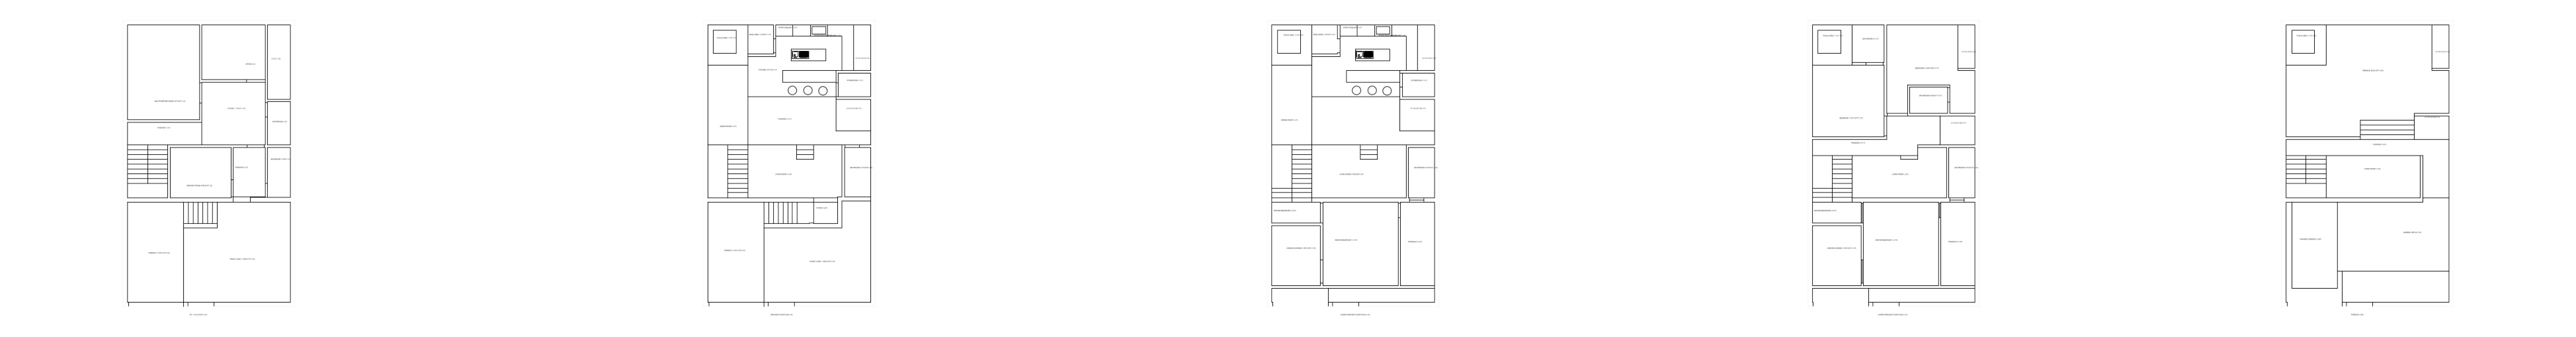

In [13]:
import sys
import os
import ezdxf
import matplotlib.pyplot as plt
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend




try:
    dxf_file = '123newmodified.dxf'  
    doc, auditor = recover.readfile(dxf_file)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)


if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    
   
    png_file = os.path.splitext(dxf_file)[0] + '.png'
    
    
    ezdxf.addons.drawing.matplotlib.qsave(layout=doc.modelspace(), 
                                          filename=png_file, 
                                          bg='#FFFFFF',  # White background color
                                          dpi=300)


img = plt.imread(png_file)


plt.figure(figsize=(50, 40))  


plt.imshow(img, alpha=1.0) 
plt.axis('off')  
plt.show()